# Project: Wrangling and Analyze Data

## Data Gathering

1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import tweepy
import time
import json
import os
import io

%matplotlib inline
%config InlineBbackend.figure_format='retina'

In [2]:
# read twitter-archive-enhanced-2.csv
df_ae = pd.read_csv('twitter-archive-enhanced-2.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# read image-predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
open(url.split('/')[-1], mode='wb').write(r.content);

In [4]:
# load tsv into DataFrame
df_ip = pd.read_csv(url.split('/')[-1], sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [5]:
# to reproduce API results, set extract_from_api to True 
extract_from_api = False

# set Twitter API keys
if extract_from_api:
    consumer_key = 'Insert your consumer key here'
    consumer_secret = 'Insert your consumer secret key here'
    access_token = 'Insert your access token here'
    access_secret = 'Insert your access secret token here'
    
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# save all tweets to a txt file
if extract_from_api:
    id_errors = []

    start = time.time()
    print('Beginning Twitter Data Query...')

    with open('tweet_json.txt', 'w') as file:
        for tweet_id in list(df_ae['tweet_id']):
            try:
                status = api.get_status(tweet_id, tweet_mode='extended')
                json.dump(status._json, file)
                file.write('\n')
            except:
                id_errors.append(tweet_id)

    end = time.time()
    print('Finished.  This took {}.'.format(end - start))

In [7]:
# read all tweets from txt file to DataFrame
df_tj = pd.DataFrame()

# open text file
with open('tweet-json.txt', encoding='utf8', mode='r') as json_file:
    
    # iterate through each line
    for line in json_file:
        
        # read each json line into a dictionary
        data = json.loads(json_file.readline())
        
        # add the id, favorite_count, and retweet_count into a DataFrame
        line_df = pd.DataFrame.from_records([{'tweet_id': data['id'], 
                                              'favorite_count': data['favorite_count'], 
                                              'retweet_count': data['retweet_count']}])
        
        # append the row to the master DataFrame
        df_tj = df_tj.append(line_df)

df_tj.reset_index(drop=True, inplace=True)
df_tj.to_csv('tweet-json.csv', index=False)

## Assessing Data



In [8]:
# view first two rows of dataframes
df_ae.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [9]:
df_ip.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [10]:
df_tj.head(2)

,favorite_count,retweet_count,tweet_id
0,33819,6514,892177421306343426
1,42908,8964,891689557279858688


In [11]:
# view summary of dataframes
df_ae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
df_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
df_tj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 3 columns):
favorite_count    1177 non-null int64
retweet_count     1177 non-null int64
tweet_id          1177 non-null int64
dtypes: int64(3)
memory usage: 27.7 KB


In [14]:
# view summary of numeric columns for dataframes
df_ae.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
df_ip.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [16]:
df_tj.describe()

,favorite_count,retweet_count,tweet_id
count,1177.000000,1177.000000,1.177000e+03
mean,7901.181818,3107.338997,7.426493e+17
std,11536.383916,5458.476288,6.851760e+16
min,0.000000,2.000000,6.660209e+17
25%,1339.000000,613.000000,6.783968e+17
50%,3553.000000,1460.000000,7.193678e+17
75%,9872.000000,3628.000000,7.992971e+17
max,131075.000000,79515.000000,8.921774e+17


In [17]:
# explore denominator of ratings
df_ae.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
# explore numerator of ratings
df_ae.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [19]:
# count dog names
df_ae.name.value_counts()

None            745
a                55
Charlie          12
Oliver           11
Lucy             11
Cooper           11
Tucker           10
Lola             10
Penny            10
Winston           9
Bo                9
Sadie             8
the               8
an                7
Daisy             7
Bailey            7
Buddy             7
Toby              7
Jax               6
Koda              6
Rusty             6
Milo              6
Oscar             6
Stanley           6
Dave              6
Leo               6
Scout             6
Jack              6
Bella             6
Oakley            5
               ... 
Evy               1
Alexander         1
Ito               1
Danny             1
Fynn              1
Sunshine          1
Flurpson          1
Alexanderson      1
Baron             1
Josep             1
Pippin            1
Chevy             1
Alf               1
Bruiser           1
Jarvis            1
Kramer            1
Rumble            1
Florence          1
Stormy            1


In [20]:
# check for duplicate tweets
df_ip.tweet_id.duplicated().sum()

0

In [21]:
df_tj.tweet_id.duplicated().sum()

0

In [22]:
df_ae.tweet_id.duplicated().sum()

0

In [23]:
# count image predictions which are not dogs
df_ip.query('(p1_dog == False) and (p2_dog == False) and (p3_dog == False)').count()

tweet_id    324
jpg_url     324
img_num     324
p1          324
p1_conf     324
p1_dog      324
p2          324
p2_conf     324
p2_dog      324
p3          324
p3_conf     324
p3_dog      324
dtype: int64

### Quality issues
1. Some dog names are missing

2. Retweets might capture the same dog with a different tweet id

3. Replies do not have images

4. Rating denominator and numerator have many outliers

5. Timestamp column is a string

6. Source displays url that affects consistency of data

7. There are 324 image predictions which are not dogs

8. Too many unnecessary columns for our data analytics

### Tidiness issues
1. Merge the four columns for stages of dog (doggo, pupper, puppo, floofer) into one category column

2. Merge tables into df_ae dataframe

## Cleaning Data

In [24]:
# Make copies of original pieces of data
df_ae_clean = df_ae.copy()
df_ip_clean = df_ip.copy()
df_tj_clean = df_tj.copy()

### Issue #1: Some dog names are missing

#### Define: 
- Replace with NaN if no name is found from df_ae
- Some names with lowercase seem to be invalid names so we are gonna replace those names as well

#### Code

In [25]:
# count number of 'none' dog names
(df_ae_clean.name == 'None').sum()

745

In [26]:
# list of lowercase dog names and 'None'
lower_list = list(df_ae_clean[df_ae_clean.name.str.islower()].name.value_counts().index)
lower_list.append('None')
lower_list

['a',
 'the',
 'an',
 'very',
 'one',
 'quite',
 'just',
 'not',
 'mad',
 'getting',
 'actually',
 'officially',
 'his',
 'my',
 'old',
 'light',
 'by',
 'such',
 'incredibly',
 'life',
 'unacceptable',
 'this',
 'space',
 'infuriating',
 'all',
 'None']

In [27]:
# replace all other lowercase names and 'None' with NaN
df_ae_clean.name = df_ae_clean.name.replace(lower_list, np.nan)

#### Test

In [28]:
# check cleaned names
df_ae_clean.name.value_counts()

Charlie           12
Cooper            11
Lucy              11
Oliver            11
Tucker            10
Lola              10
Penny             10
Bo                 9
Winston            9
Sadie              8
Buddy              7
Toby               7
Bailey             7
Daisy              7
Oscar              6
Rusty              6
Dave               6
Leo                6
Stanley            6
Jax                6
Koda               6
Milo               6
Bella              6
Scout              6
Jack               6
Larry              5
George             5
Sammy              5
Bentley            5
Louis              5
                  ..
JD                 1
Goliath            1
Kellogg            1
Birf               1
Puff               1
Perry              1
Blue               1
Napolean           1
Clyde              1
Michelangelope     1
Eleanor            1
Chesney            1
Rumpole            1
Fwed               1
Loomis             1
Wishes             1
Scott        

### Issue #2: Retweets might capture the same dog with a different tweet id

#### Define
- Drop retweeted rows
- Drop retweeted columns

#### Code

In [29]:
#drop the retweeted rows
df_ae_clean = df_ae_clean[df_ae_clean.retweeted_status_id.isnull()]

In [30]:
# confirm all retweeted rows are dropped
df_ae_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          1391 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [31]:
#drop the retweeted columns
df_ae_clean = df_ae_clean.drop(labels=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

#### Test

In [32]:
# confirm all retweeted columns are dropped
df_ae_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     1391 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ KB


### Issue #3: Replies do not have images

#### Define
- Drop in_reply_to_status_id and in_reply_to_user_id

#### Code

In [33]:
#drop the reply rows
df_ae_clean = df_ae_clean[df_ae_clean.in_reply_to_status_id.isnull()]

In [34]:
# confirm all reply rows are dropped
df_ae_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2097 non-null int64
in_reply_to_status_id    0 non-null float64
in_reply_to_user_id      0 non-null float64
timestamp                2097 non-null object
source                   2097 non-null object
text                     2097 non-null object
expanded_urls            2094 non-null object
rating_numerator         2097 non-null int64
rating_denominator       2097 non-null int64
name                     1390 non-null object
doggo                    2097 non-null object
floofer                  2097 non-null object
pupper                   2097 non-null object
puppo                    2097 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 245.7+ KB


In [35]:
df_ae_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)

#### Test

In [36]:
df_ae_clean.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


### Issue #4: Rating denominator and numerator have many outliers

#### Define
- From df_ae, keep rows where rating_numerator is between 1-15
- From df_ae, keep rows where rating_denominator is 10

#### Code

In [37]:
# only keep rows where numerator is between 1-15 and the denominator is 10
df_ae_clean = df_ae_clean[(df_ae_clean.rating_numerator > 0) & (df_ae_clean.rating_numerator < 16) &
                          (df_ae_clean.rating_denominator == 10)]

#### Test

In [38]:
df_ae_clean.rating_numerator.value_counts()

12    486
10    436
11    413
13    287
9     152
8      98
7      51
14     38
5      34
6      32
3      19
4      15
2       9
1       4
Name: rating_numerator, dtype: int64

In [39]:
df_ae_clean.rating_denominator.value_counts()

10    2074
Name: rating_denominator, dtype: int64

### Issue #5: Timestamp column is a string

#### Define
- From df_ae, convert timestamp to datetime

#### Code

In [40]:
df_ae_clean.timestamp = pd.to_datetime(df_ae_clean.timestamp)

#### Test

In [41]:
df_ae_clean.timestamp.dtypes

dtype('<M8[ns]')

### Issue #6: There is missing data in expanded urls

#### Define
- Strip source to remove the HTML link

#### Code

In [42]:
# define function to strip source link
def strip_url(x):
    return x.split('>', 1)[-1][:-4]

In [43]:
# clean source column
df_ae_clean['source'] = df_ae_clean['source'].apply(strip_url)

#### Test

In [44]:
df_ae_clean['source'].value_counts()

Twitter for iPhone     1942
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

### Issue #7: There are 324 image predictions which are not dogs

#### Define
- Drop rows where all predictions are not dogs

#### Code

In [45]:
# only keep rows with at least one dog prediction
df_ip_clean = df_ip_clean.query('(p1_dog != False) or (p2_dog != False) or (p3_dog != False)')

#### Test

In [46]:
df_ip_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1751 non-null int64
jpg_url     1751 non-null object
img_num     1751 non-null int64
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1751 non-null object
p2_conf     1751 non-null float64
p2_dog      1751 non-null bool
p3          1751 non-null object
p3_conf     1751 non-null float64
p3_dog      1751 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 141.9+ KB


### Issue #8: Too many unnecessary columns for our data analytics

#### Define
- Source, text and expanded urls are not useful for our data analytics afterward

#### Code

In [47]:
#drop the unnecessary columns
df_ae_clean = df_ae_clean.drop(labels=['source', 'text', 'expanded_urls'], axis=1)

#### Test

In [48]:
df_ae_clean.head(2)

,tweet_id,timestamp,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,13,10,Tilly,None,None,None,None


### Issue #9: Merge tables into df_ae dataframe

#### Define
- Joining df_ae with df_tj and df_ip

#### Code

In [49]:
#inner join df_ae with df_tj by tweet id
df_tweet1 = df_tj_clean.merge(df_ae_clean, left_on='tweet_id', right_on='tweet_id')

#### Test

In [50]:
df_tweet1.head(2)

,favorite_count,retweet_count,tweet_id,timestamp,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,33819,6514,892177421306343426,2017-08-01 00:17:27,13,10,Tilly,None,None,None,None
1,42908,8964,891689557279858688,2017-07-30 15:58:51,13,10,Darla,None,None,None,None


In [51]:
#inner join df_ae with df_tj by tweet id
df_tweet = df_tweet1.merge(df_ip_clean, left_on='tweet_id', right_on='tweet_id')

In [52]:
df_tweet.head(2)

,favorite_count,retweet_count,tweet_id,timestamp,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,33819,6514,892177421306343426,2017-08-01 00:17:27,13,10,Tilly,None,None,None,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,42908,8964,891689557279858688,2017-07-30 15:58:51,13,10,Darla,None,None,None,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False


### Issue #10: Merge the four columns for stages of dog (doggo, pupper, puppo, floofer) into one category column

#### Define
- Merge dog stages into one column and drop previous stage columns

#### Code

In [53]:
# replace all NaN and 'None' dog_stage
df_tweet.doggo.replace('None', '', inplace=True)
df_tweet.doggo.replace(np.NaN, '', inplace=True)
df_tweet.floofer.replace('None', '', inplace=True)
df_tweet.floofer.replace(np.NaN, '', inplace=True)
df_tweet.pupper.replace('None', '', inplace=True)
df_tweet.pupper.replace(np.NaN, '', inplace=True)
df_tweet.puppo.replace('None', '', inplace=True)
df_tweet.puppo.replace(np.NaN, '', inplace=True)

In [54]:
# group by dog_stage
df_tweet.groupby(['doggo', 'floofer', 'pupper', 'puppo']).size().reset_index().rename(columns={0: 'count'})

,doggo,floofer,pupper,puppo,count
0,,,,,703
1,,,,puppo,8
2,,,pupper,,89
3,,floofer,,,4
4,doggo,,,,27
5,doggo,,pupper,,4
6,doggo,floofer,,,1


In [55]:
# combine dog_stages into a single column
df_tweet['dog_stage'] = df_tweet.doggo + df_tweet.floofer + df_tweet.pupper + df_tweet.puppo

# rename rows for multiple stages
df_tweet.loc[df_tweet.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
df_tweet.loc[df_tweet.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [56]:
# drop previous dog stage columns
df_tweet.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [57]:
df_tweet.dog_stage.value_counts()

                  703
pupper             89
doggo              27
puppo               8
floofer             4
doggo, pupper       4
doggo, floofer      1
Name: dog_stage, dtype: int64

## Storing Data

In [58]:
df_tweet.to_csv('twitter_archive_master.csv', index=False)
df_ip_clean.to_csv('twitter_image_prediction_master.csv', index=False)

## Analyzing and Visualizing Data

In [59]:
# extract and sort timestamp, favorites, and retweets
engagement = df_tweet[['timestamp', 'favorite_count', 'retweet_count']].sort_values(['timestamp', 'favorite_count'])

In [60]:
# create moving averages for better insights
window = 30
rolling_likes = engagement.favorite_count.rolling(window=window).mean()[window-1:]
rolling_retweets = engagement.retweet_count.rolling(window=window).mean()[window-1:]

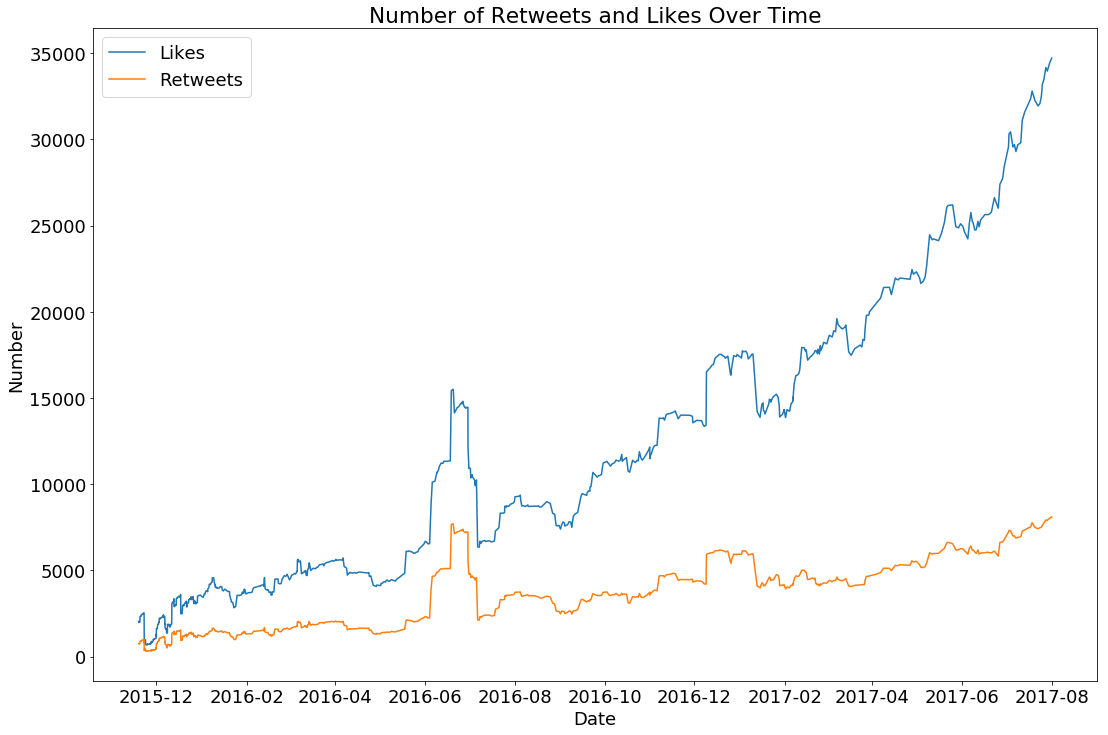

In [61]:
# plot a line graph
plt.figure(figsize=(18, 12))
plt.rcParams.update({'font.size': 18})
plt.title('Number of Retweets and Likes Over Time')
plt.xlabel('Date')
plt.ylabel('Number')
plt.plot(engagement.timestamp[window-1:], rolling_likes, label='Likes')
plt.plot(engagement.timestamp[window-1:], rolling_retweets, label='Retweets')
plt.legend()

In [62]:
# find the average likes by dog stage
dog_stage_likes = df_tweet[['dog_stage', 'favorite_count']]
dog_stage_likes = dog_stage_likes.query('dog_stage != ""')
dog_stage_likes = dog_stage_likes.groupby('dog_stage').mean()

x_pos = list(dog_stage_likes.index.str.capitalize())
y_pos = list(dog_stage_likes.favorite_count)

<Container object of 6 artists>

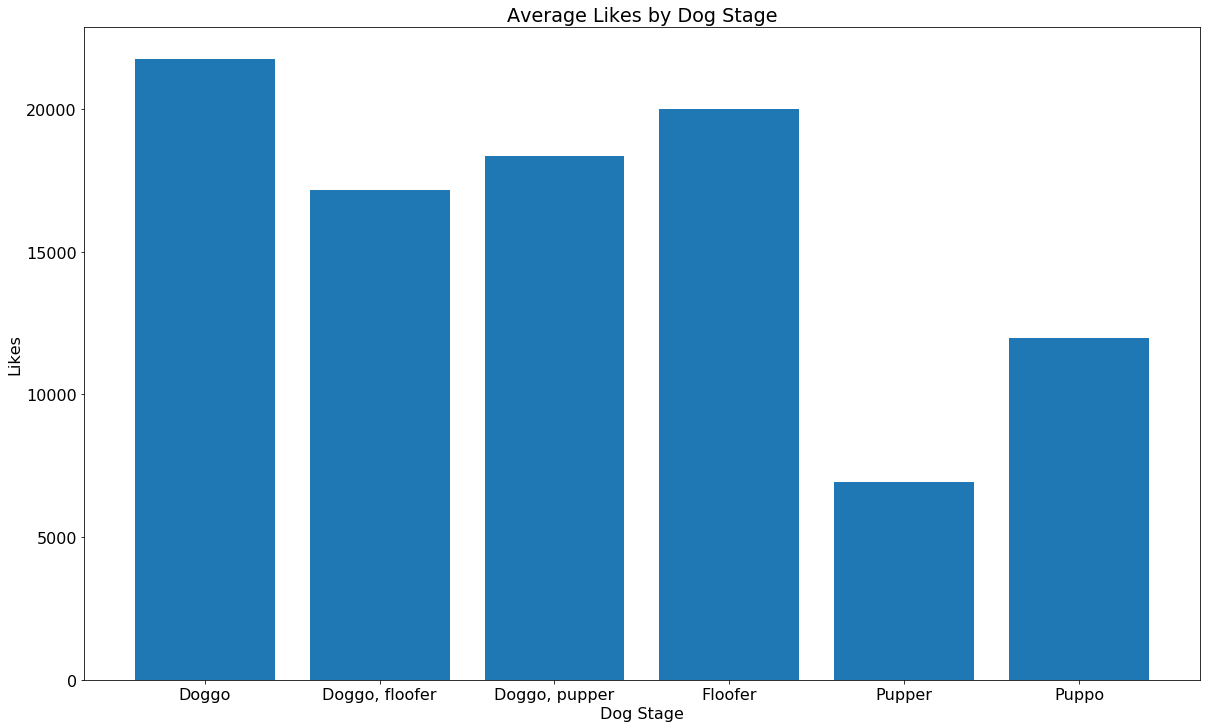

In [63]:
# plot a bar chart
plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 16})
plt.title('Average Likes by Dog Stage')
plt.xlabel('Dog Stage')
plt.ylabel('Likes')
plt.bar(x_pos, y_pos)

### Insights:
1. We can see that retweets and likes are rising with time.

2. With more retweets, people also like posts more.

3. Among all dog stages, doggo and floofer get most likes.

### Visualization